# Variational Autoencoder for Audio
In this notebook, I will attempt to implement a VAE for generating similar sounds as those in a Spoken Digit audio Database. 

In [1]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')

In [2]:
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)    

File loaded as ../SpokenDigitDB.pkl.gz


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
Class        4509 non-null category
Magnitude    4509 non-null object
PShift       4509 non-null int64
Phase        4509 non-null object
SIndex       4509 non-null int64
TStretch     4509 non-null float64
Wave         4509 non-null object
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 215.9+ KB


Maximum length is: 138 


(array([  60.,   63.,  123.,  138.,  123.,  180.,  177.,  180.,  186.,
         135.,  276.,  171.,  255.,  216.,  195.,  174.,  174.,  132.,
         111.,  156.,  225.,  126.,  162.,   90.,   90.,   54.,   27.,
          72.,   42.,   33.,   75.,   57.,   39.,   42.,   15.,   33.,
          15.,   12.,    9.,    6.,    6.,    3.,    3.,   12.,    3.,
           3.,    9.,    3.,    9.,    9.]),
 array([  33. ,   35.1,   37.2,   39.3,   41.4,   43.5,   45.6,   47.7,
          49.8,   51.9,   54. ,   56.1,   58.2,   60.3,   62.4,   64.5,
          66.6,   68.7,   70.8,   72.9,   75. ,   77.1,   79.2,   81.3,
          83.4,   85.5,   87.6,   89.7,   91.8,   93.9,   96. ,   98.1,
         100.2,  102.3,  104.4,  106.5,  108.6,  110.7,  112.8,  114.9,
         117. ,  119.1,  121.2,  123.3,  125.4,  127.5,  129.6,  131.7,
         133.8,  135.9,  138. ]),
 <a list of 50 Patch objects>)

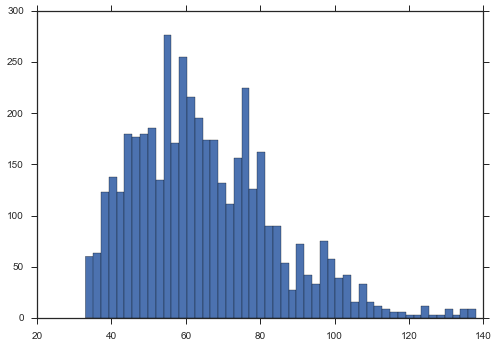

In [4]:
mag = df.Magnitude
mgs = [np.shape(x)[1] for x in mag]
maxlen = np.max(mgs)
print('Maximum length is: {} '.format(maxlen))
plt.hist(mgs,50)

In [13]:
# Padding & Truncating
maxlen = 84
pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.zeros([a.shape[0],n - a.shape[1]])))

df.Magnitude = df.Magnitude.apply(pad,args=(maxlen,))  # MaxLen Truncation Voodoo :D
df.Phase     = df.Phase.apply(pad,args=(maxlen,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[1] for x in df.Phase]))

[84]
[84]


## Plot Samples from Database

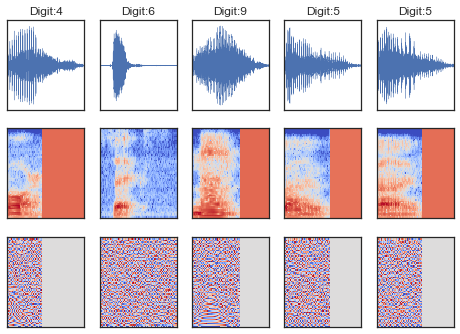

In [14]:
seaborn.set(style='white')

# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,[sidx,sidx])    

for i,j in enumerate(sidx):
    if i<k:
        subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        title('Digit:{1}'.format(j,df.Class[j]))
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().get_xaxis().set_visible(False)

    elif (i>=k and i<2*k):
        subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        
    else:
        subplot(3,k,i+1)
        specshow(df.Phase[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])        

In [33]:
# np.max(df.Magnitude[j])
# np.max(df.Phase[j])

3.1386644840240479

In [28]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

## VAE for Audio

In [27]:
# Imports
from keras.layers import Input, Dense, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from scipy.stats import norm

In [ ]:
mag_in = Input(shape=(num_feat,maxlen),name='magnitude')
phi_in = Input(shape=(num_feat,maxlen),name='phase')

# Mag & Phi Encoder
mconv1 = Conv2D(12,(3,5),padding='same',activation='relu')(mag_in)
mconv1 = MaxPooling2D((2,2))(mconv1)
mconv2 = Conv2D(12,(3,3),padding='same',activation='relu')(mconv1)
mconv2 = MaxPooling2D((2,3))(mconv2)
mconv  = Flatten()(mconv2)

pconv1 = Conv2D(12,(3,5),padding='same',activation='relu')(phi_in)
pconv1 = MaxPooling2D((2,2))(pconv1)
pconv2 = Conv2D(12,(3,3),padding='same',activation='relu')(pconv1)
pconv2 = MaxPooling2D((2,3))(pconv2)
pconv  = Flatten()(pconv2)

shared_layer = Dense(256)
shared_layer